In [1]:
import json

In [2]:
with open("result/ground_truth.json") as f:
    ground_truth = json.load(f)

with open("result/convnext_outputs.json") as f:
    convnext_outputs = json.load(f)

with open("result/cropnet_outputs.json") as f:
    cropnet_outputs = json.load(f)

with open("result/vit_outputs.json") as f:
    vit_outputs = json.load(f)

In [14]:
import numpy as np


def get_all_wrong(ground_truth, output1, output2, output3):
    all_wrong = []
    for key in ground_truth:
        predict_1 = np.argmax(output1[key])
        predict_2 = np.argmax(output2[key])
        predict_3 = np.argmax(output3[key])
        if (
            predict_1 != ground_truth[key]
            and predict_2 != ground_truth[key]
            and predict_3 != ground_truth[key]
        ):
            all_wrong.append(key)
    return all_wrong


all_wrong = get_all_wrong(ground_truth, convnext_outputs, cropnet_outputs, vit_outputs)
print(all_wrong)
print(len(all_wrong))

['3243085170.jpg', '2194364157.jpg', '710791285.jpg', '3496438505.jpg', '376862597.jpg', '1205478806.jpg', '1891755915.jpg', '2089741702.jpg', '62053025.jpg', '1046156726.jpg', '2948468563.jpg', '3274661195.jpg', '3644947505.jpg', '1644503085.jpg', '1761872222.jpg', '1482718698.jpg', '1329201937.jpg', '3813128079.jpg', '3237815335.jpg', '3305945509.jpg', '2028369861.jpg', '601263353.jpg', '4262410116.jpg', '958551982.jpg', '2856542971.jpg', '2953205129.jpg', '3634041994.jpg', '828472143.jpg', '1453190275.jpg', '1530010093.jpg', '1683677421.jpg', '3986821371.jpg', '2839492411.jpg', '2933094268.jpg', '881681381.jpg', '812733394.jpg', '2771434768.jpg', '4286158151.jpg', '1832233045.jpg', '3308428199.jpg', '447826793.jpg', '2754537497.jpg', '845926406.jpg', '3344412896.jpg', '2623834949.jpg', '1534401639.jpg', '1123269893.jpg', '422752547.jpg', '3809682538.jpg']
49


In [15]:
merged_outputs = {}
for key in ground_truth:
    merged_outputs[key] = [0, 0, 0, 0, 0]
    for i in range(len(convnext_outputs[key])):
        merged_outputs[key][i] = (
            convnext_outputs[key][i] + cropnet_outputs[key][i] + vit_outputs[key][i]
        ) / 3

In [16]:
def classify(ground_truth, output, all_wrong):
    prob_diff = []
    for key in ground_truth:
        if key in all_wrong:
            continue
        predict = np.argmax(output[key])
        if ground_truth[key] != predict:
            # key is wrong, but some are correct
            predict_prob = output[key][predict]
            ground_truth_prob = output[key][ground_truth[key]]
            prob_dif = predict_prob - ground_truth_prob
            prob_diff.append(prob_dif)
    return prob_diff


prob_diff_convnext = classify(ground_truth, convnext_outputs, all_wrong)
prob_diff_cropnet = classify(ground_truth, cropnet_outputs, all_wrong)
prob_diff_vit = classify(ground_truth, vit_outputs, all_wrong)
prob_diff_merged = classify(ground_truth, merged_outputs, all_wrong)

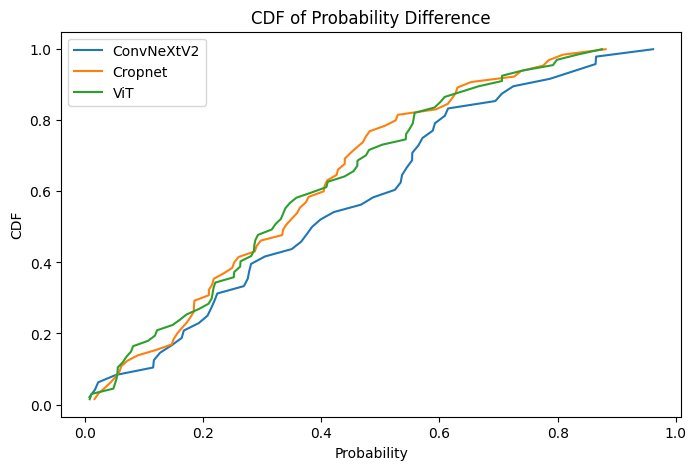

In [25]:
import matplotlib.pyplot as plt
import numpy as np


def plot_cdf(data, label):
    sorted_data = np.sort(data)
    # print(sorted_data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    plt.plot(sorted_data, cdf, label=label)


# bigger
fig = plt.figure(figsize=(8, 5))
plot_cdf(prob_diff_convnext, "ConvNeXtV2")
plot_cdf(prob_diff_cropnet, "Cropnet")
plot_cdf(prob_diff_vit, "ViT")
# plot_cdf(prob_diff_merged, "merged")
plt.title("CDF of Probability Difference")
plt.xlabel("Probability")
plt.ylabel("CDF")
plt.legend()

# tight layout
plt.savefig("image/cdf.pdf", format="pdf", dpi=600, bbox_inches="tight")

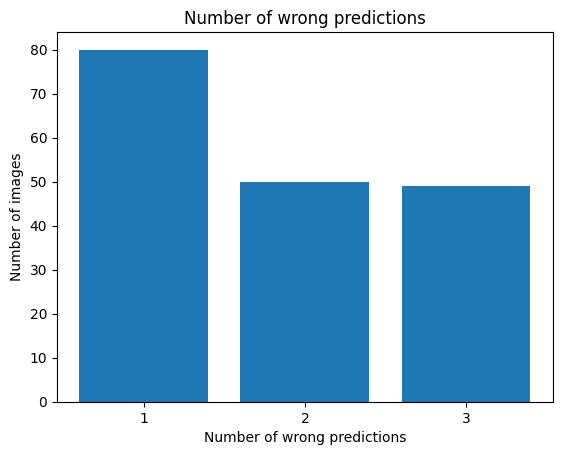

In [26]:
def get_num_wrong(ground_truth, output1, output2, output3):
    num_wrong_array = [0, 0, 0]
    for key in ground_truth:
        predict_1 = np.argmax(output1[key])
        predict_2 = np.argmax(output2[key])
        predict_3 = np.argmax(output3[key])
        wrong_num = 0
        if predict_1 != ground_truth[key]:
            wrong_num += 1
        if predict_2 != ground_truth[key]:
            wrong_num += 1
        if predict_3 != ground_truth[key]:
            wrong_num += 1
        if wrong_num == 0:
            continue
        num_wrong_array[wrong_num - 1] += 1
    return num_wrong_array


num_wrong_array = get_num_wrong(
    ground_truth, convnext_outputs, cropnet_outputs, vit_outputs
)
# print bar chart
plt.figure()
plt.bar(["1", "2", "3"], num_wrong_array)
plt.title("Number of wrong predictions")
plt.xlabel("Number of wrong predictions")
plt.ylabel("Number of images")
plt.show()